# Replicating Education Crowdfunding Results


### What is this?
This notebook provides step-by-step instructions for replicating the results from our recent study of fairness-accuracy trade-offs on the Education Crowdfunding dataset.

### What has already been done?
To make reproducing the bias analysis easier as well as provide more visibility into our results, this notebook starts off from a point where the public DonorsChoose dataset has already been injested into a postgres database and a grid of models (described in Supplementary Table 2 of our study) has already been run. We've made available a database dump with both the underlying data and the results of our model runs (see below for instructions on getting it set up).

### What if I want to re-run the models from scratch?
You can also re-run (or add to) the model grid starting from the public DonorsChoose data using our open-source machine learning pipeline `triage`, which makes it easier to run any model with a `scikit-learn`-style interface over temporal validation sets in a "top k" setting. See this repo's readme file for some tips on getting set up as well as pointers to a repo with an example of running triage using these data.


In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

from IPython.display import display 
from itertools import permutations
from jinja2 import Template
import dateparser


from ohio.ext.numpy import pg_copy_to_table

## Getting Set Up

We've provided an extract of the data in a postgres dump file (postgres 11.10), available at: 

https://dsapp-public-data-migrated.s3.amazonaws.com/education_crowdfunding_replication.dmp 

(NOTE: this file is about 16 GB compressed, so may take some time to download depending on your connection). You can load the data into your own postgres server using (you'll need to create the `education_crowdfunding` database first and fill in the host, port, and user below):

```bash
pg_restore -h {POSTGRES_HOST} -p {POSTGRES_PORT} -d education_crowdfunding -U {POSTGRES_USER} -O -j 8 education_crowdfunding_replication.dmp
```

Note that the dump file is compressed and you'll need a server with around 500 GB of free disk space.

Loading this file will populate your database with several schemas:
- **public**: The raw data from donors choose as well as some tables with calculated features and intermediate modeling tables
- **model_metadata**: Information about the models we ran, such as model types and hyperparameters (models were run with `triage`, which generates this schema. In `triage` a "model group" specifies a type of model and associated hyperparameter values, while a "model" is an instantiation of a given model group on a specific temporal validation split). Note that this schema contains information on other model runs with this dataset, in addition to the run used for the current study of fairness-accuracy trade-offs.
- **test_results**: Validation set statistics and predictions for the models. Here, `test_results.predictions` contains project-level predicted scores from each model in the grid, while `test_results.evaluations` contains aggregated summary statistics for each model.
- **train_results**: Training set statistics for the models, including feature importances.
- **features**: Intermediate tables containing calculated features from the `triage` run.
- **bias_working**: Intermediate tables from the bias analysis, as well as the mapping table between projects and school poverty levels, `bias_working.entity_demos`.
- **bias_results_submitted**: Results of the fairness-accuracy trade-offs from the study as submitted (see below to use these to replicate the figures from the study).
- **bias_results**: Empty bias analysis results tables that will be populated by re-running the fairness adjustments (see below for instructions).


Finally, to connect to the database, you'll need a yaml file named `db_profile.yaml` in the same directory as this notebook with your connection info:
```yaml
host: {POSTGRES_HOST}
user: {POSTGRES_USER}
db: education_crowdfunding
pass: {POSTGRES_PASSWORD}
port: {POSTGRES_PORT}
```


In [11]:
with open('db_profile.yaml') as fd:
    config = yaml.full_load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgresql",
        host=config["host"],
        username=config["user"],
        database=config["db"],
        password=config["pass"],
        port=config["port"],
    )
    engine_donors = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

/tmp/ipykernel_15553/636033927.py:3: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  dburl = sqlalchemy.engine.url.URL(


Next, we define a helper function that will pull the results of the various strategies explored in the study. The table `model_adjustment_results_plevel` contains performance statistics for each model type we ran with and without adjusting for recall equity and `composite_results_plevel` contains performance statistics for a stategy that selects the best-performing model for each subgroup separately (we'll look at generating these tables from the raw modeling results as well below). The query below uses four different strategies to choose a model for each temporal validation split based on these performance statistics:

In [12]:
def get_bias_results(engine, schema='bias_results'):
    sql = """
    WITH mg_rns AS (
      SELECT *,
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
      FROM {schema}.model_adjustment_results_plevel
      WHERE past_train_end_time = train_end_time
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ratio AS max_recall_ratio,
           r.base_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.base_frac_not_highest AS frac_not_highest,
           r.base_frac_highest AS frac_highest,
           r.base_min_score_not_highest AS min_score_not_highest, 
           r.base_min_score_highest AS min_score_highest, 
           r.base_mean_score_not_highest AS mean_score_not_highest, 
           r.base_mean_score_highest AS mean_score_highest,
           r.base_precision_not_highest AS precision_not_highest, 
           r.base_precision_highest AS precision_highest, 
           r.base_prevalence_not_highest AS prevalence_not_highest, 
           r.base_prevalence_highest AS prevalence_highest, 
           r.base_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.base_positive_prevalence_highest AS positive_prevalence_highest,            
           r.base_positive_rate_not_highest AS positive_rate_not_highest, 
           r.base_positive_rate_highest AS positive_rate_highest
    FROM {schema}.model_adjustment_results_plevel r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Model selection on last time before adjustment, with adjustment applied
    SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
           r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.adj_frac_not_highest AS frac_not_highest,
           r.adj_frac_highest AS frac_highest, 
           r.adj_min_score_not_highest AS min_score_not_highest, 
           r.adj_min_score_highest AS min_score_highest, 
           r.adj_mean_score_not_highest AS mean_score_not_highest, 
           r.adj_mean_score_highest AS mean_score_highest, 
           r.adj_precision_not_highest AS precision_not_highest, 
           r.adj_precision_highest AS precision_highest, 
           r.adj_prevalence_not_highest AS prevalence_not_highest, 
           r.adj_prevalence_highest AS prevalence_highest, 
           r.adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.model_adjustment_results_plevel r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Model selection on last time after adjustment, with adjustment applied
    SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
           r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.adj_frac_not_highest AS frac_not_highest,
           r.adj_frac_highest AS frac_highest, 
           r.adj_min_score_not_highest AS min_score_not_highest, 
           r.adj_min_score_highest AS min_score_highest, 
           r.adj_mean_score_not_highest AS mean_score_not_highest, 
           r.adj_mean_score_highest AS mean_score_highest, 
           r.adj_precision_not_highest AS precision_not_highest, 
           r.adj_precision_highest AS precision_highest, 
           r.adj_prevalence_not_highest AS prevalence_not_highest, 
           r.adj_prevalence_highest AS prevalence_highest, 
           r.adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.model_adjustment_results_plevel r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Composite model
    SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
          train_end_time, past_train_end_time,
          list_size, metric, parameter,
          value,
          max_recall_ratio,
          recall_not_highest_to_highest,
          frac_not_highest,
          frac_highest, 
          min_score_not_highest, 
          min_score_highest, 
          mean_score_not_highest, 
          mean_score_highest, 
          precision_not_highest, 
          precision_highest, 
          prevalence_not_highest, 
          prevalence_highest, 
          positive_prevalence_not_highest, 
          positive_prevalence_highest, 
          positive_rate_not_highest, 
          positive_rate_highest
    FROM {schema}.composite_results_plevel
    WHERE train_end_time > past_train_end_time
    ;
    """.format(schema=schema)

    ts_df = pd.read_sql(sql, engine)

    ts_df['dataset'] = 'Education Crowdfunding'

    ts_df['strategy'] = ts_df['strategy'].map({
        'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
        'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
        'Composite Model - Adjusted': 'Mitigated - Composite Model',
        'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
    })
    
    return ts_df

## Reproducing Figures from the Study

As a starting point, we can reproduce the figures from the study directly using the data in the `bias_results_submitted` schema:

In [13]:
ts_df3 = get_bias_results(engine_donors, 'bias_results')
print(ts_df3.columns)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column r.base_positive_prevalence_not_highest does not exist
LINE 32:            r.base_positive_prevalence_not_highest AS positiv...
                    ^

[SQL: 
    WITH mg_rns AS (
      SELECT *,
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
      FROM bias_results.model_adjustment_results_plevel
      WHERE past_train_end_time = train_end_time
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ratio AS max_recall_ratio,
           r.base_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.base_frac_not_highest AS frac_not_highest,
           r.base_frac_highest AS frac_highest,
           r.base_min_score_not_highest AS min_score_not_highest, 
           r.base_min_score_highest AS min_score_highest, 
           r.base_mean_score_not_highest AS mean_score_not_highest, 
           r.base_mean_score_highest AS mean_score_highest,
           r.base_precision_not_highest AS precision_not_highest, 
           r.base_precision_highest AS precision_highest, 
           r.base_prevalence_not_highest AS prevalence_not_highest, 
           r.base_prevalence_highest AS prevalence_highest, 
           r.base_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.base_positive_prevalence_highest AS positive_prevalence_highest,            
           r.base_positive_rate_not_highest AS positive_rate_not_highest, 
           r.base_positive_rate_highest AS positive_rate_highest
    FROM bias_results.model_adjustment_results_plevel r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Model selection on last time before adjustment, with adjustment applied
    SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
           r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.adj_frac_not_highest AS frac_not_highest,
           r.adj_frac_highest AS frac_highest, 
           r.adj_min_score_not_highest AS min_score_not_highest, 
           r.adj_min_score_highest AS min_score_highest, 
           r.adj_mean_score_not_highest AS mean_score_not_highest, 
           r.adj_mean_score_highest AS mean_score_highest, 
           r.adj_precision_not_highest AS precision_not_highest, 
           r.adj_precision_highest AS precision_highest, 
           r.adj_prevalence_not_highest AS prevalence_not_highest, 
           r.adj_prevalence_highest AS prevalence_highest, 
           r.adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.adj_positive_rate_highest AS positive_rate_highest
    FROM bias_results.model_adjustment_results_plevel r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Model selection on last time after adjustment, with adjustment applied
    SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
           r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.adj_frac_not_highest AS frac_not_highest,
           r.adj_frac_highest AS frac_highest, 
           r.adj_min_score_not_highest AS min_score_not_highest, 
           r.adj_min_score_highest AS min_score_highest, 
           r.adj_mean_score_not_highest AS mean_score_not_highest, 
           r.adj_mean_score_highest AS mean_score_highest, 
           r.adj_precision_not_highest AS precision_not_highest, 
           r.adj_precision_highest AS precision_highest, 
           r.adj_prevalence_not_highest AS prevalence_not_highest, 
           r.adj_prevalence_highest AS prevalence_highest, 
           r.adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.adj_positive_rate_highest AS positive_rate_highest
    FROM bias_results.model_adjustment_results_plevel r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time > r.past_train_end_time

    UNION ALL

    -- Composite model
    SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
          train_end_time, past_train_end_time,
          list_size, metric, parameter,
          value,
          max_recall_ratio,
          recall_not_highest_to_highest,
          frac_not_highest,
          frac_highest, 
          min_score_not_highest, 
          min_score_highest, 
          mean_score_not_highest, 
          mean_score_highest, 
          precision_not_highest, 
          precision_highest, 
          prevalence_not_highest, 
          prevalence_highest, 
          positive_prevalence_not_highest, 
          positive_prevalence_highest, 
          positive_rate_not_highest, 
          positive_rate_highest
    FROM bias_results.composite_results_plevel
    WHERE train_end_time > past_train_end_time
    ;
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [17]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1,3,5,7,9,11])
months_fmt = mdates.DateFormatter('%b %y')

In [19]:
def line_plot_over_time(y, y_label, ax=None, strategies=["Unmitigated", "Mitigated - Single Model"]):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [20]:
def line_plots_over_time(ys, y_labels, ax=None, strategies=["Unmitigated", "Mitigated - Single Model"]):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]    
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    markers = ["*", "o", "s", "^", "P"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    for i, y in enumerate(ys):
        y_label = y_labels[i]
        marker = markers[i]
        sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker=marker, ax=ax, label=y_label)
    ax.set_xlabel('Test Set Date', fontsize=14)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ax.get_legend()
    
    return ax

### Supplementary Figure 3
Comparing model precision (a) and disparity (b) metrics over time fordifferent model selection strategies in the Education Crowdfunding policy context.

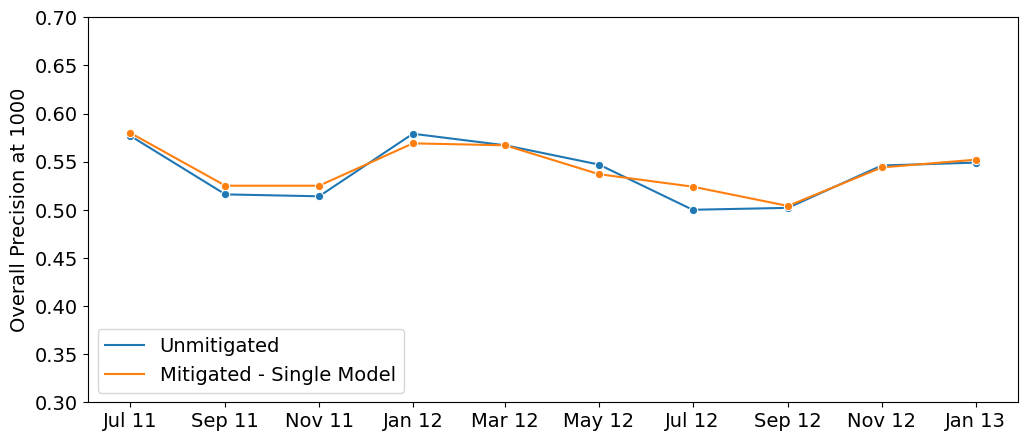

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14, loc='lower left')

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

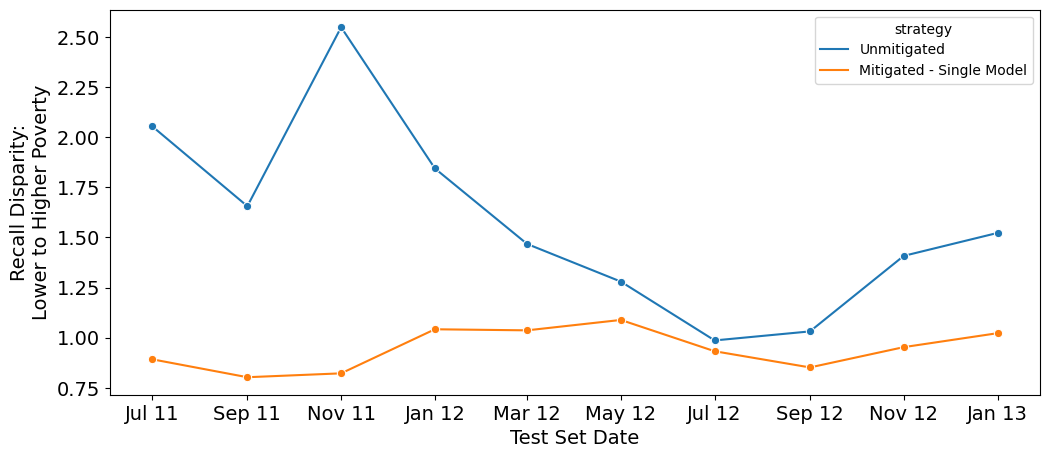

In [22]:
line_plot_over_time(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty')

<AxesSubplot: xlabel='Test Set Date', ylabel='Fraction of list set to highest plevel'>

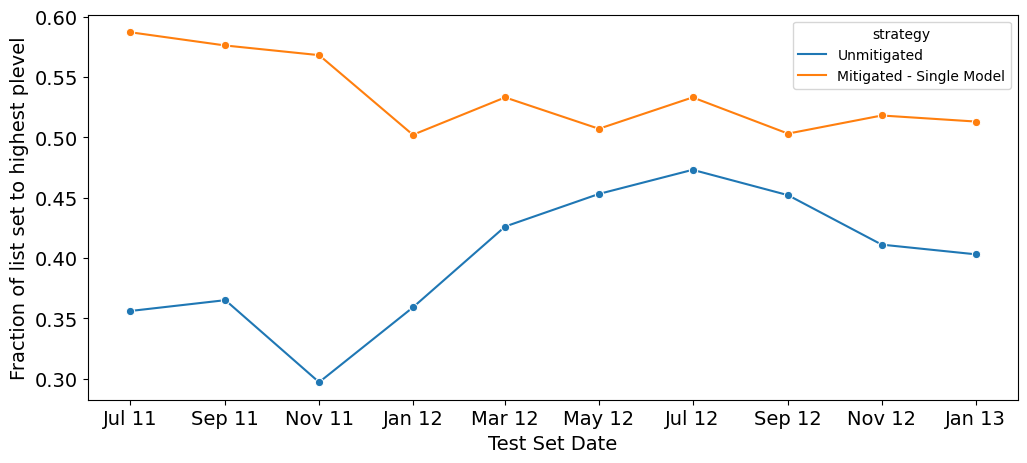

In [23]:
line_plot_over_time(y="frac_highest", y_label='Fraction of list set to highest plevel')

<AxesSubplot: xlabel='Test Set Date', ylabel='Prevalence Highest'>

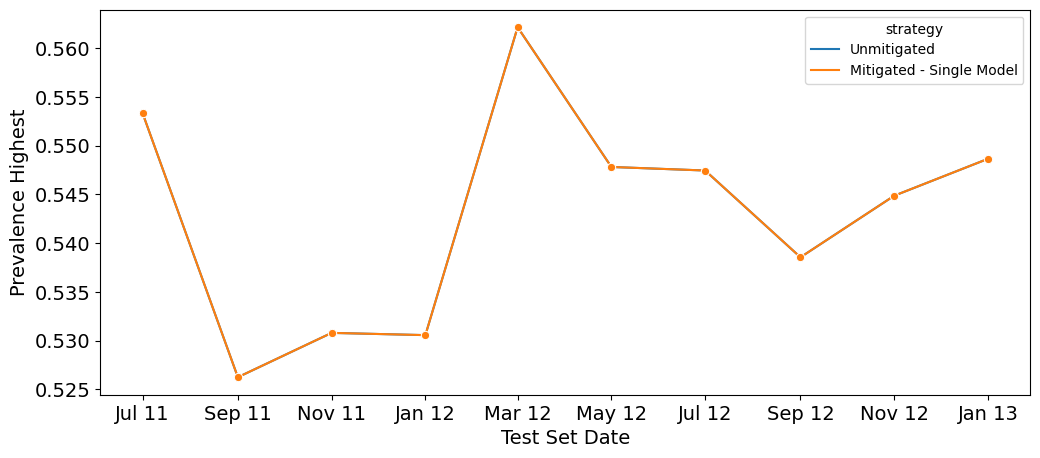

In [24]:
line_plot_over_time(y="prevalence_highest", y_label='Prevalence Highest')

<AxesSubplot: xlabel='Test Set Date', ylabel='Prevalence Highest'>

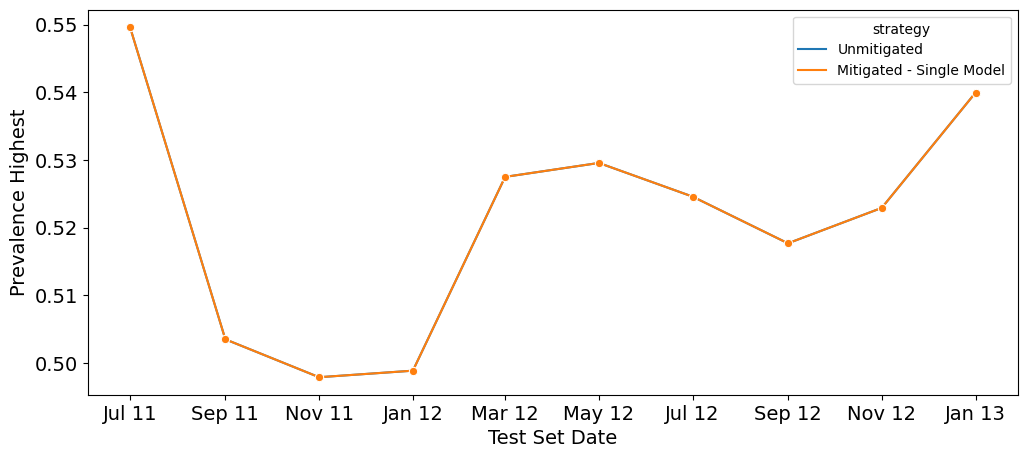

In [25]:
line_plot_over_time(y="positive_prevalence_highest", y_label='Prevalence Highest')

<AxesSubplot: xlabel='Test Set Date', ylabel='Positive Rate Highest'>

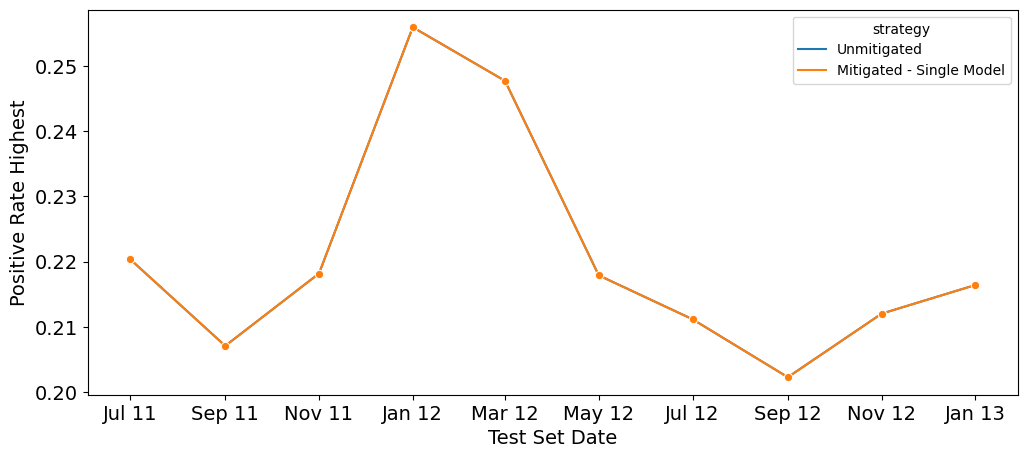

In [26]:
line_plot_over_time(y="positive_rate_highest", y_label='Positive Rate Highest')

<AxesSubplot: xlabel='Test Set Date', ylabel='Positive Rate Not Highest'>

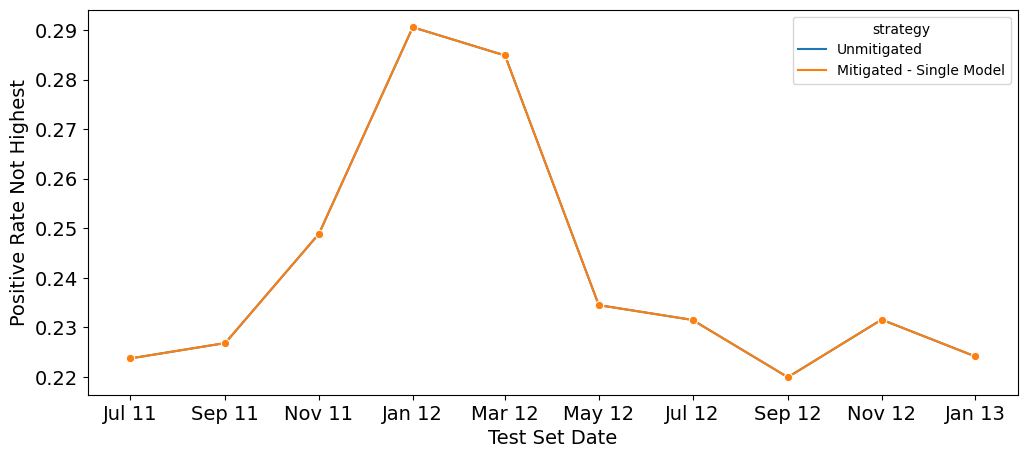

In [27]:
line_plot_over_time(y="positive_rate_not_highest", y_label='Positive Rate Not Highest')

<AxesSubplot: xlabel='Test Set Date', ylabel='Min Score (Not Highest - Highest)'>

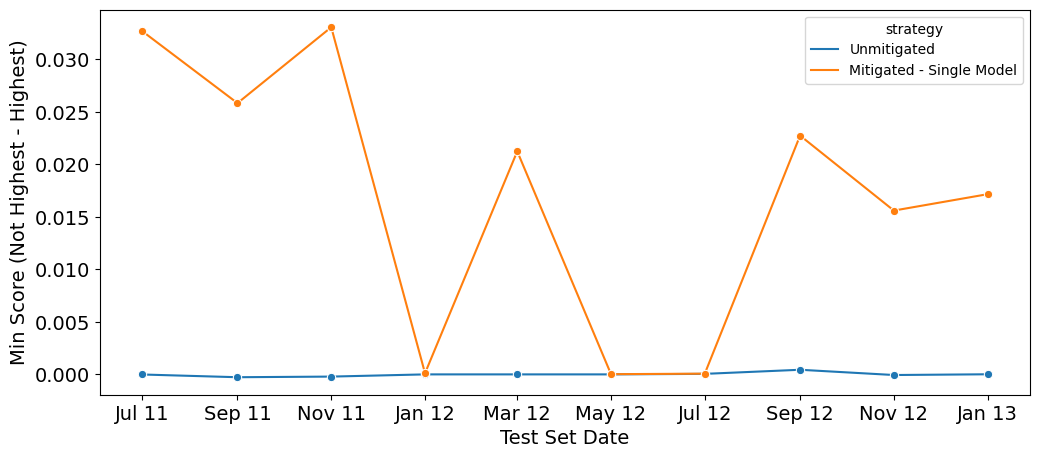

In [28]:
ts_df3['min_score_diff'] = ts_df3['min_score_not_highest'] - ts_df3['min_score_highest']
ts_df3['mean_score_diff'] = ts_df3['mean_score_not_highest'] - ts_df3['mean_score_highest']
line_plot_over_time(y="min_score_diff", y_label='Min Score (Not Highest - Highest)')

<AxesSubplot: xlabel='Test Set Date', ylabel='Mean Score (Not Highest - Highest)'>

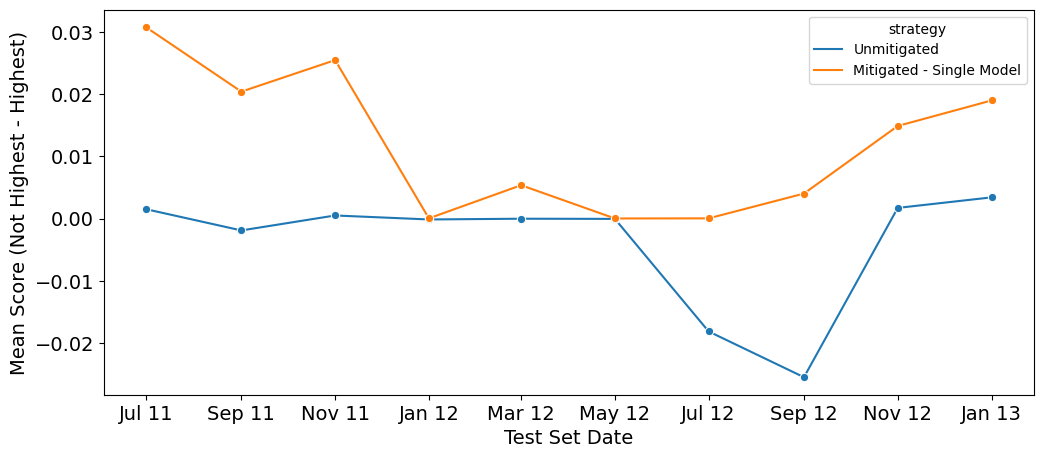

In [29]:
line_plot_over_time(y="mean_score_diff", y_label='Mean Score (Not Highest - Highest)')

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision Highest'>

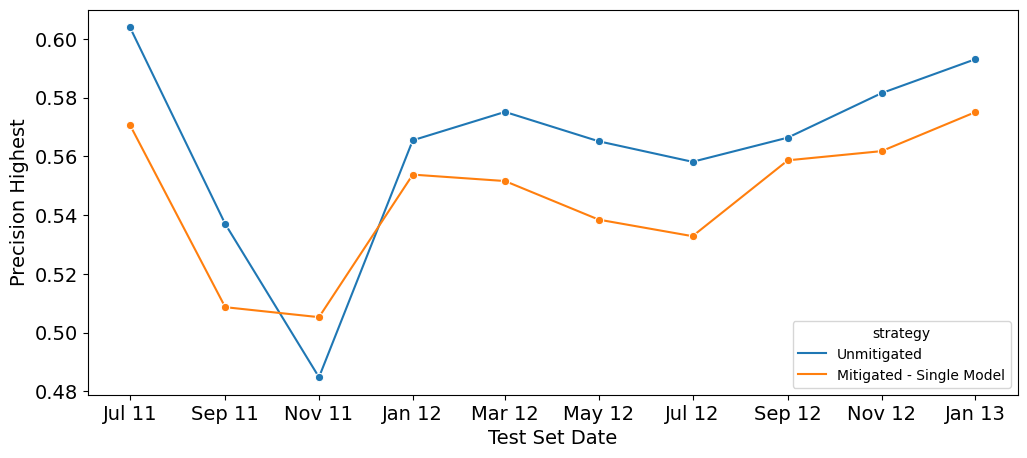

In [30]:
line_plot_over_time(y="precision_highest", y_label='Precision Highest')

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision Not Highest'>

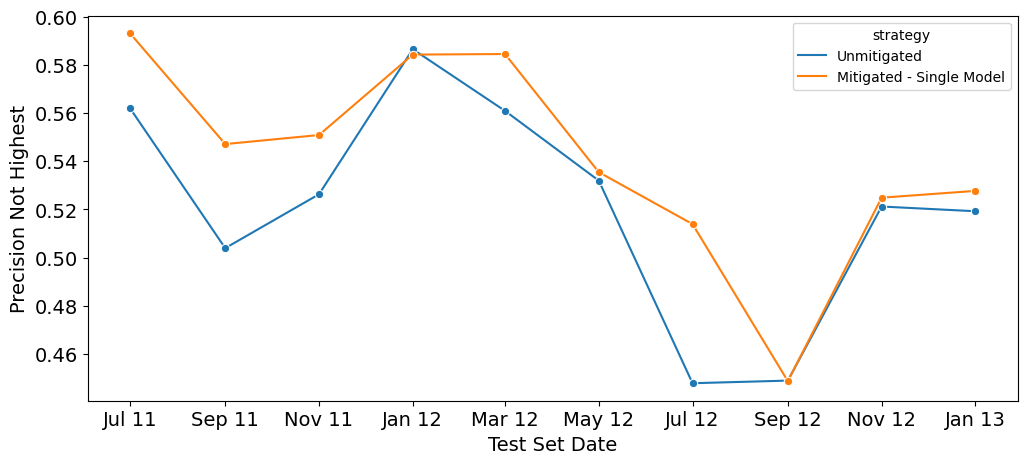

In [31]:
line_plot_over_time(y="precision_not_highest", y_label='Precision Not Highest')

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

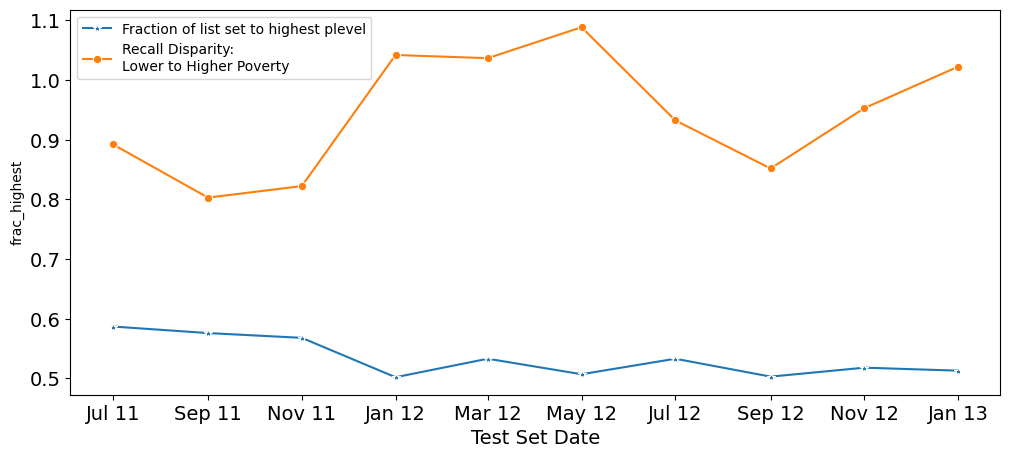

In [32]:
ys = ["frac_highest", "recall_not_highest_to_highest"]
y_labels = ['Fraction of list set to highest plevel', 'Recall Disparity:\nLower to Higher Poverty']
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

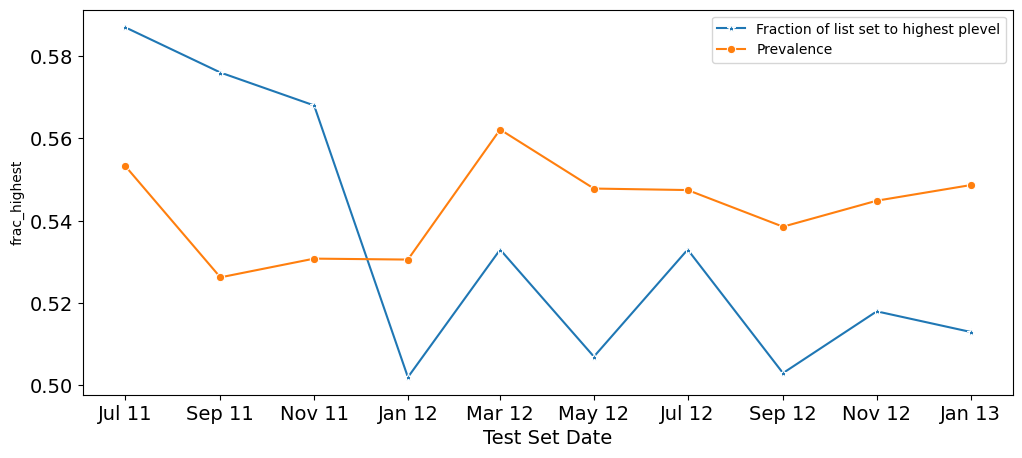

In [33]:
ys = ["frac_highest", "prevalence_highest"]
y_labels = ['Fraction of list set to highest plevel', 'Prevalence']
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

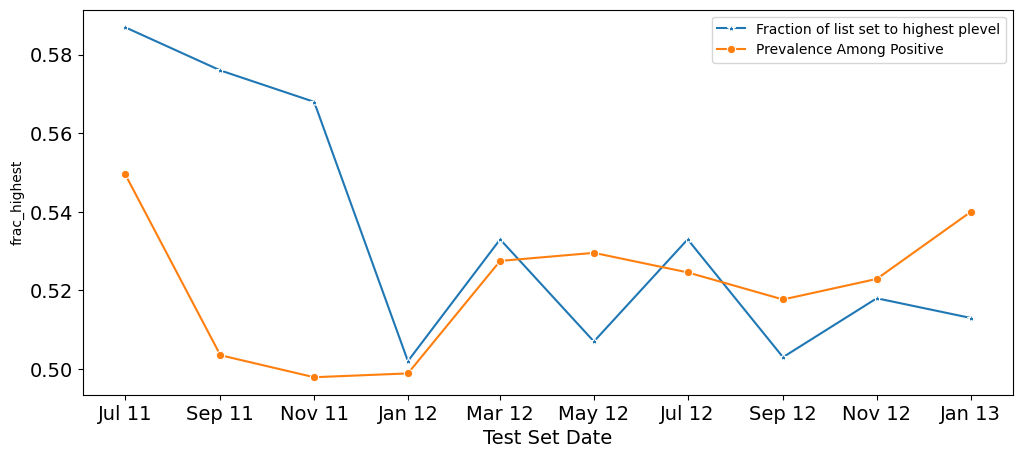

In [34]:
ys = ["frac_highest", "positive_prevalence_highest"]
y_labels = ['Fraction of list set to highest plevel', 'Prevalence Among Positive ']
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

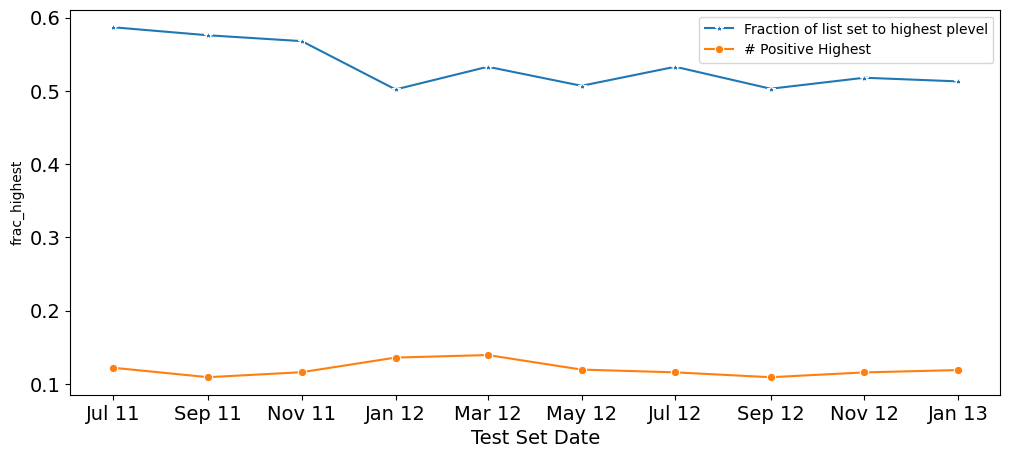

In [35]:
ts_df3['n_positive_highest'] = ts_df3['prevalence_highest'] *ts_df3['positive_rate_highest']
ys = ["frac_highest", "n_positive_highest"]
y_labels = ['Fraction of list set to highest plevel', '# Positive Highest']
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

<AxesSubplot: xlabel='past_train_end_time'>

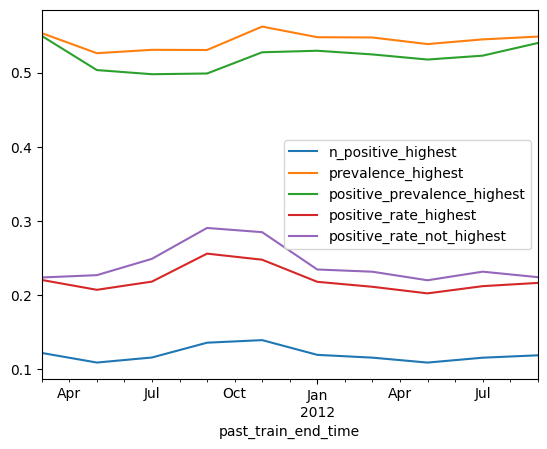

In [40]:
df_slice = ts_df3[['n_positive_highest', 'prevalence_highest', 'positive_prevalence_highest', 'positive_rate_highest', 'positive_rate_not_highest', 'past_train_end_time']]
grouped = df_slice.groupby("past_train_end_time").mean()
grouped.plot()

In [41]:
prev_year = grouped.shift(1)
diff_frame = grouped - prev_year
for metric in diff_frame.columns:
    ts_df3[f'delta_{metric}'] = ts_df3["past_train_end_time"].apply(lambda x: diff_frame.loc[x, metric])

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

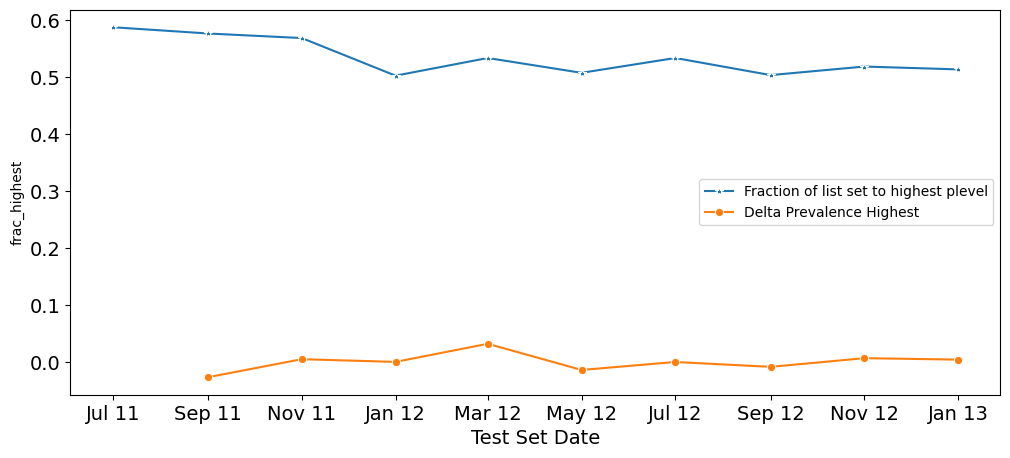

In [42]:
ys = ["frac_highest", "delta_prevalence_highest"]
y_labels = ['Fraction of list set to highest plevel', 'Delta Prevalence Highest']
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

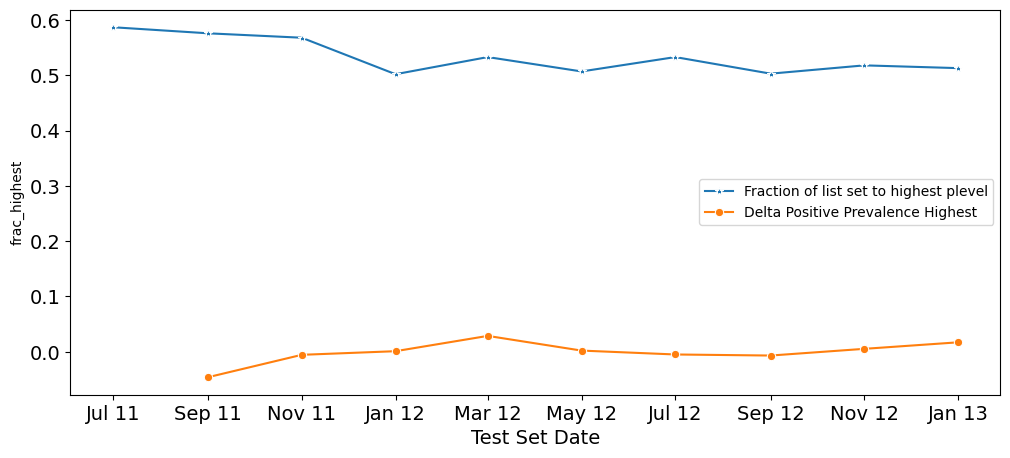

In [43]:
ys = ["frac_highest", "delta_positive_prevalence_highest"]
y_labels = ['Fraction of list set to highest plevel', 'Delta Positive Prevalence Highest']
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

<AxesSubplot: xlabel='Test Set Date', ylabel='frac_highest'>

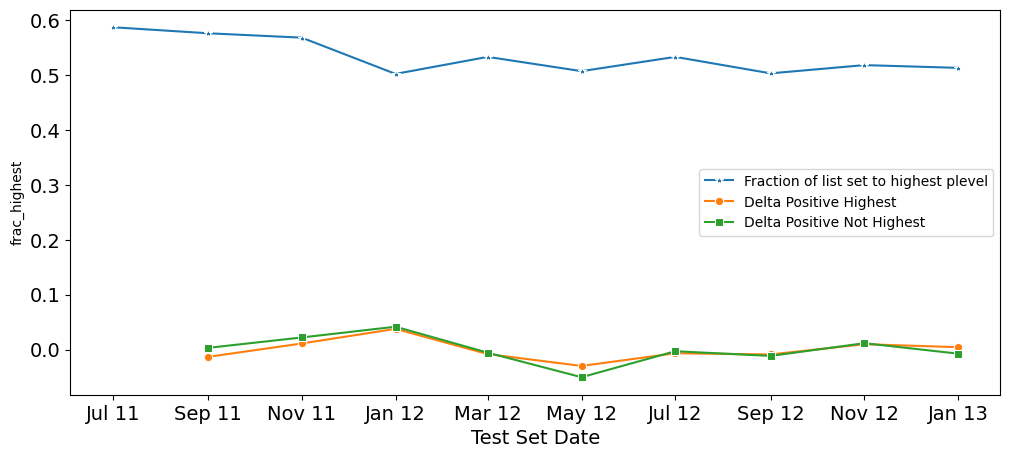

In [39]:
ys = ["frac_highest", "delta_positive_rate_highest", "delta_positive_rate_not_highest"]
y_labels = ['Fraction of list set to highest plevel', 'Delta Positive Highest', "Delta Positive Not Highest"]
line_plots_over_time(ys=ys, y_labels=y_labels, strategies=["Mitigated - Single Model"])

### Figure 2 (Education Crowdfunding Points)
Comparing trade-offs across strategies

In [24]:
# renaming a few columns to ensure consistency across datasets
comp_df = ts_df3.rename(
    {'recall_not_highest_to_highest': 'recall_disp', 
     'frac_not_highest': 'frac_grp1', 
     'frac_highest': 'frac_grp2'
    }, axis='columns')

/tmp/ipykernel_7644/3761170441.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),


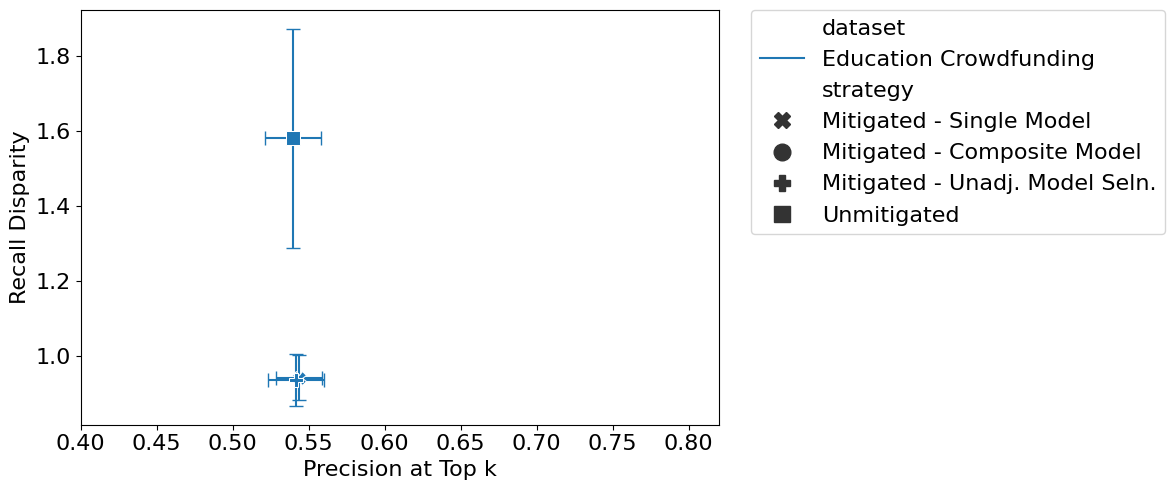

In [25]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
              style='strategy',
              style_order=sty_ord,
              markers=['X', 'o', 'P', 's'],
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

## Reproducing the Bias Adjustments

The following code will re-run the bias analysis itself starting from the model results. Note that there is some randomness in the code (breaking ties between projects with the same score as well as breaking ties between models with the same performance on a given test set), so the results you get here may not be exactly identical to the results above, but should be statistically consistent with them.

**NOTE: Running all of the results here can take a fair amount of time (around 2-3 hours on a db.m5.2xlarge AWS RDS instance), so be sure to be working in a screen/tmux setting if running the notebook remotely!**

In [14]:
def validate_dates(params):
        for past, future in params['date_pairs']:
            if dateparser.parse(past) > dateparser.parse(future):
                raise ValueError('Error! Cannot validate on the past. %s should be no earlier than %s.' % (future, past))

In [15]:
ENTITY_DEMO_FILES = {
    'joco': {
        'sql_tmpl': 'joco_entity_demos.sql.tmpl',
        'check_sql': """
            WITH all_matches AS (
                SELECT COUNT(DISTINCT ((mg.model_config->'matchdatetime')::VARCHAR)::TIMESTAMP) AS num_match
                FROM tmp_bias_models
                JOIN model_metadata.model_groups mg USING(model_group_id)
            )
            SELECT num_match = 1 AS pass_check
            FROM all_matches
        """
        }
}

In [16]:
def create_entity_demos(engine, params, entity_demos):
        sql_file = ENTITY_DEMO_FILES[entity_demos]['sql_tmpl']
        sql = Template(open(sql_file, 'r').read()).render(params)
        self.engine.execute(sql)
        self.engine.execute("COMMIT")

        # consistency check:
        check_sql = ENTITY_DEMO_FILES[entity_demos]['check_sql']
        if not engine.execute(check_sql).fetchall()[0][0]:
            raise RuntimeError('Entity Demos failed consistency check:\n %s' % check_sql)

        return '%s.entity_demos' % params['schema']

We also declare a few debugging functions


In [26]:
if True:
    def input_func(s):
        return
else:
    def input_func(s):
        input(s)
        return

In [18]:
def print_sql_table(table_name, engine, schema="bias_working"):
    return pd.read_sql(f"SELECT * FROM {schema}.{table_name};", engine)

In [19]:
def print_sql_tables(table_names, engine):
    for table_name in table_names:
        print(f"{'X'*10}")
        print(f"Table: {table_name}")
        print(print_sql_table(table_name, engine))
        print(f"{'X'*10}")
    return

Currently, this code assumes your data is in a postgres database containing modeling results in the format of our open-source `triage` machine learning pipeline, including temporal validation splits.


Next, let's clear out anything in the `bias_results` schema (these should start empty, unless you've already run anything since loading the database):

In [25]:
engine_donors.execute('TRUNCATE TABLE bias_results.composite_results_plevel;')
engine_donors.execute('TRUNCATE TABLE bias_results.model_adjustment_results_plevel;')
engine_donors.execute('COMMIT;')

Because of the size of the data, we're going to do this iteratively over subsets of validation set dates to avoid running into memory issues, but depending on your dataset and database server, you could instead simply run the `RecallAdjuster` once with the full set of date pairs.

Some notes on the inputs here:
- **date_pairs**: The code needs a "previous" validation set to learn the group-specific thresholds to equalize recall on the "current" validation set. Additionally, for every date used as a "previous" validation set, we include a pair with this set as both the "previous" and "current" date (to allow for selecting a model based on post-adjustment performance on the previous set)
- **pg_role**: Allows you to set a different role in postgres if needed, but generally will be the same as your postgres user
- **schema**: We'll use `bias_working` for the intermediate results of each iteration, but then will collect all of these into the `bias_results` schema
- **experiment_hashes**: Triage tracks runs of a grid of models via an "experiment" object, identified by this hash. The one coded here is for the set of models described in the study
- **list_sizes**: The overall "top k" size(s) to consider (can be a list of multiple, but if so, you'll need to be careful to modify the results query above to choose just one at a time)
- **entity_demos**: This is a postgres table containing a lookup between entities (here, projects), dates, and demographics of interest for bias analysis. Here, `bias_working.entity_demos` contains the school poverty levels determined from the project data.
- **demo_col**: The specific column of interest for the bias analysis. Here, `plevel` is the school poverty level.



In [21]:
date_pairs_all = [
 ('2011-03-01', '2011-03-01'),
 ('2011-03-01', '2011-07-01'),
 ('2011-05-01', '2011-05-01'),
 ('2011-05-01', '2011-09-01'),
 ('2011-07-01', '2011-07-01'),
 ('2011-07-01', '2011-11-01'),
 ('2011-09-01', '2011-09-01'),
 ('2011-09-01', '2012-01-01'),
 ('2011-11-01', '2011-11-01'),
 ('2011-11-01', '2012-03-01'),
 ('2012-01-01', '2012-01-01'),
 ('2012-01-01', '2012-05-01'),
 ('2012-03-01', '2012-03-01'),
 ('2012-03-01', '2012-07-01'),
 ('2012-05-01', '2012-05-01'),
 ('2012-05-01', '2012-09-01'),
 ('2012-07-01', '2012-07-01'),
 ('2012-07-01', '2012-11-01'),
 ('2012-09-01', '2012-09-01'),
 ('2012-09-01', '2013-01-01')
 ]

In [22]:
date_list = ['2011-03-01', '2011-05-01', '2011-07-01', '2011-09-01', '2011-11-01', '2012-01-01', '2012-03-01', '2012-05-01', '2012-07-01', '2012-09-01', '2012-11-01', '2013-01-01']
date_weights = {}
date_weights['2011-03-01'] = {'2011-03-01': 1.0}
date_weights['2011-05-01'] = {'2011-03-01': 1.0}
for i, date in enumerate(date_list[2:]):
    date_weights[date] = {date_list[i-1]: 0.5, date_list[i-2]: 0.5}

In [23]:
def get_weight_case_str(date_weights):
    if len(date_weights) == 0:
        return "0"
    s = "CASE"
    for future_train_end_time in date_weights:
        for train_end_time in date_weights[future_train_end_time]:
            w = date_weights[future_train_end_time][train_end_time]
            s += f" WHEN future_train_end_time = '{future_train_end_time}' AND train_end_time = '{train_end_time}' THEN {w} "
    s += "ELSE 0 END"
    return s

In [ ]:
for dp_idx in range(10):
    date_pairs = [ date_pairs_all[2*dp_idx], date_pairs_all[2*dp_idx+1] ]
    print(date_pairs)
    params = {}
    params['pg_role'] = config["user"]
    params['schema'] = 'bias_working'
    experiment_hashes = ['a33cbdb3208b0df5f4286237a6dbcf8f']
    params['experiment_hashes'] = experiment_hashes
    if isinstance(date_pairs[0], str):
        date_pairs = [date_pairs]
    params['date_pairs'] = date_pairs
    params['date_weight_case_str'] = get_weight_case_str(date_weights)
    params['list_sizes'] = [1000]
    params['demo_col'] = 'plevel'
    params['subsample'] = False
    params['bootstrap'] = False
    entity_demos='bias_working.entity_demos'
    engine=engine_donors.connect()
    validate_dates(params)
    if entity_demos.find('.') > -1:
        params['entity_demos'] = entity_demos
    elif entity_demos in ENTITY_DEMO_FILES.keys():
        params['entity_demos'] = create_entity_demos(engine, params, entity_demos)
    else:
        raise ValueError('Error: entity_demos must be either `schema.table_name` OR one of (%s)' % ', '.join(ENTITY_DEMO_FILES.keys()))

    sql = Template(open('recall_adjustment_pre.sql.tmpl', 'r').read()).render(**params)
    engine.execute(sql)
    engine.execute("COMMIT")
    
            
    input_func(f"Date Pair: {date_pairs} pre sql done")
    
    sql = "SELECT %s, COUNT(*) AS num FROM %s GROUP BY 1 ORDER BY 2 DESC" % (params['demo_col'], params['entity_demos'])
    res = engine.execute(sql).fetchall()
    params['demo_values'] = [r[0] for r in res]
    params['demo_permutations'] = list(permutations(params['demo_values'], 2))

    
    # pre-calculate the results for all models, date pairs
    sql = Template(open('recall_adjustment-verbose.sql.tmpl', 'r').read()).render(**params)
    engine.execute(sql)
    engine.execute("COMMIT")
    
    
    input_func(f"Date Pair: {date_pairs} adjustment done")
    engine.close()
    engine_donors.execute("""
        INSERT INTO bias_results.model_adjustment_results_plevel 
        SELECT * FROM bias_working.model_adjustment_results_plevel;
    """)
    
    engine_donors.execute("""
        INSERT INTO bias_results.composite_results_plevel 
        SELECT * FROM bias_working.composite_results_plevel;
    """)
    
    engine_donors.execute("""
        INSERT INTO bias_results.model_adjustment_group_k_plevel 
        SELECT * FROM bias_working.model_adjustment_group_k_plevel gkp WHERE (gkp.model_group_id, gkp.train_end_time, gkp.demo_value, gkp.group_k) NOT IN (SELECT * FROM bias_results.model_adjustment_group_k_plevel)
    """)
    
    engine_donors.execute("COMMIT;")

[('2011-03-01', '2011-03-01'), ('2011-03-01', '2011-07-01')]


Finally, we can read in the results of this new bias adjustment run and regenerate the figures as above:

In [15]:
ts_df3 = get_bias_results(engine_donors, 'bias_results')

In [28]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1,3,5,7,9,11])
months_fmt = mdates.DateFormatter('%b %y')

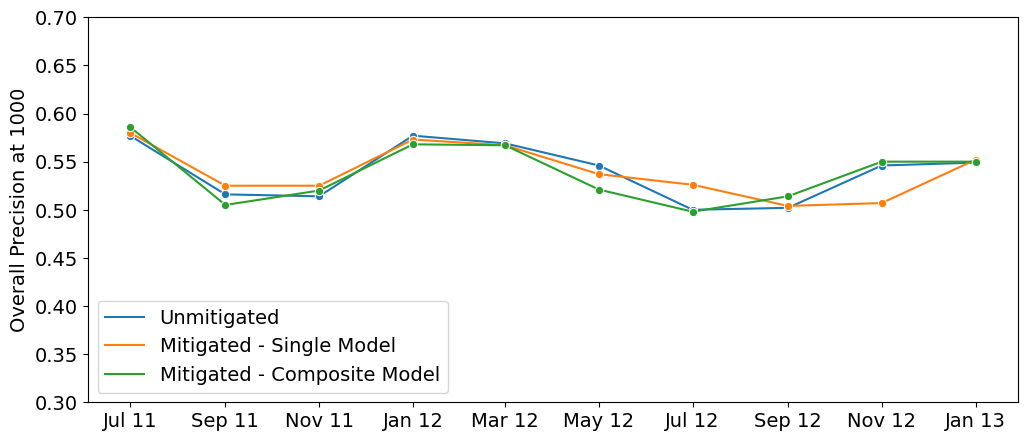

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14, loc='lower left')

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

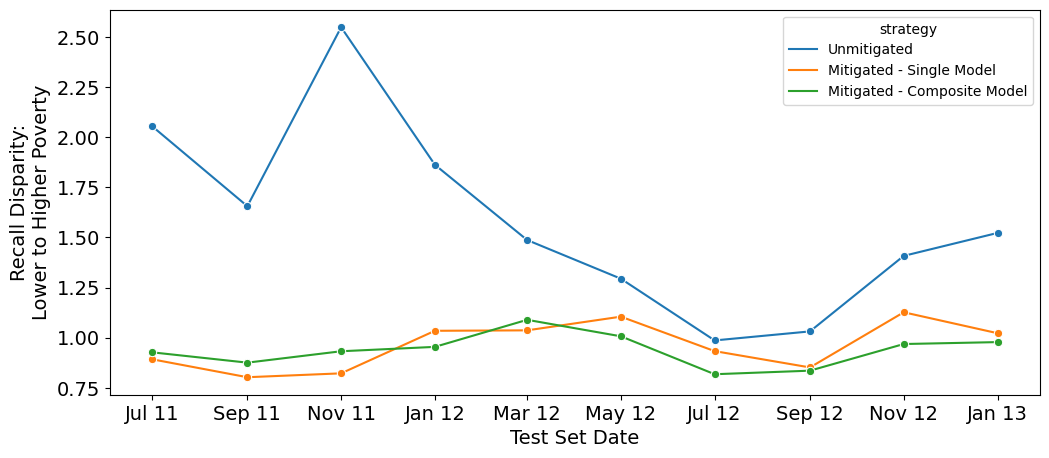

In [30]:
line_plot_over_time(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty')

In [85]:
# renaming a few columns to ensure consistency across datasets
comp_df = ts_df3.rename(
    {'recall_not_highest_to_highest': 'recall_disp', 
     'frac_not_highest': 'frac_grp1', 
     'frac_highest': 'frac_grp2'
    }, axis='columns')

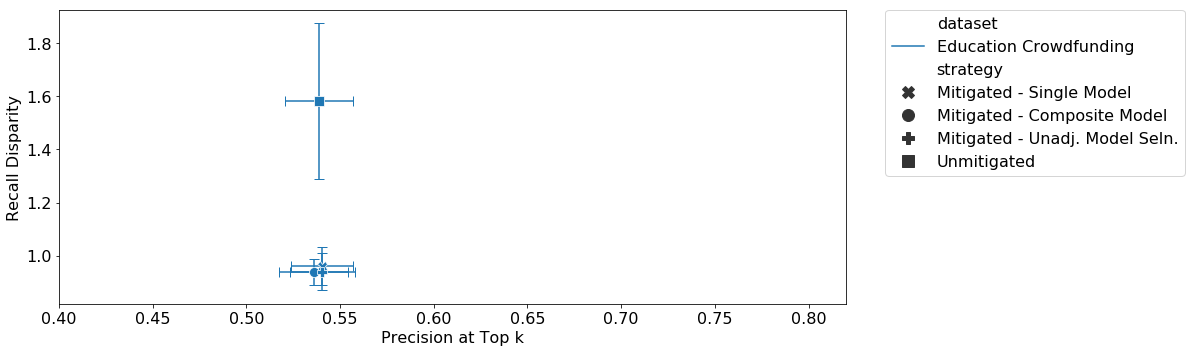

In [86]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
              style='strategy',
              style_order=sty_ord,
              markers=['X', 'o', 'P', 's'],
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

If you want to explore the results further, `bias_results.model_adjustment_results_plevel` holds the results from your run for each model, including the validation set the thresholds were learned based on (`past_train_end_time`), the validation set they were applied to (`train_end_time`), and the unadjusted (`base_` columns) and adjusted (`adj_` columns) results in terms of accuracy, disparities, and the composition of the selected list. The `bias_results.composite_results_plevel` has a similar structure for the composite models created by selecting the best-performing model for each subgroup separately (so note there's no overall `model_id` ehre, but separate columns for the model group used for each subgroup)



In [105]:
pd.read_sql("SELECT * FROM bias_results.model_adjustment_results_plevel LIMIT 5", engine_donors)

,model_id,model_group_id,train_end_time,list_size,past_train_end_time,metric,parameter,base_value,base_max_recall_ratio,base_recall_highest_to_not_highest,base_recall_not_highest_to_highest,base_frac_highest,base_recall_highest,base_frac_not_highest,base_recall_not_highest,adj_value,adj_max_recall_ratio,adj_recall_highest_to_not_highest,adj_recall_not_highest_to_highest,adj_frac_highest,adj_recall_highest,adj_frac_not_highest,adj_recall_not_highest,value_diff,recall_ratio_diff
0,5095,849,2011-03-01,1000,2011-03-01,precision@,1000_abs,0.331,1.018469,0.981866,1.018469,0.611,0.021009,0.389,0.021397,0.331,1.006229,1.006229,0.993810,0.617,0.021238,0.383,0.021106,0.000,-0.012240
1,5096,853,2011-03-01,1000,2011-03-01,precision@,1000_abs,0.394,1.151647,0.868321,1.151647,0.575,0.023636,0.425,0.027220,0.394,1.002070,1.002070,0.997934,0.611,0.025234,0.389,0.025182,0.000,-0.149577
2,5097,847,2011-03-01,1000,2011-03-01,precision@,1000_abs,0.413,1.075628,0.929690,1.075628,0.599,0.025577,0.401,0.027511,0.409,1.002040,0.997964,1.002040,0.618,0.026148,0.382,0.026201,-0.004,-0.073587
3,5098,852,2011-03-01,1000,2011-03-01,precision@,1000_abs,0.411,1.095997,0.912411,1.095997,0.540,0.025234,0.460,0.027656,0.409,1.002040,0.997964,1.002040,0.561,0.026148,0.439,0.026201,-0.002,-0.093957
4,5100,857,2011-03-01,1000,2011-03-01,precision@,1000_abs,0.396,1.000819,1.000819,0.999182,0.582,0.025348,0.418,0.025328,0.395,1.003703,0.996311,1.003703,0.581,0.025234,0.419,0.025328,-0.001,0.002884
